# The significance and size of effects

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

Let us get the data and put it into a dataframe.

In [2]:
placebo = [54, 51, 58, 44, 55, 52, 42, 47, 58, 46]
drug = [54, 73, 53, 70, 73, 68, 52, 65, 65]
dosage = placebo + drug
label = ['P']*len(placebo) + ['D']*len(drug)
df = pd.DataFrame(dict(dosage=dosage, label=label))
df

,dosage,label
0,54,P
1,51,P
2,58,P
3,44,P
4,55,P
5,52,P
6,42,P
7,47,P
8,58,P
9,46,P


The "mean" size of the effect in our sample is about 13.

In [3]:
actuals = df.groupby('label').dosage.mean()
actuals

label
D    63.666667
P    50.700000
Name: dosage, dtype: float64

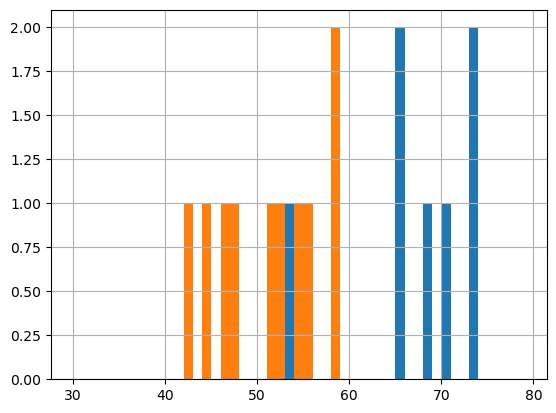

In [4]:
df.groupby('label').dosage.hist(bins=np.arange(30, 80, 1));

In [5]:
actual_effect = actuals['D'] - actuals['P']
actual_effect

12.966666666666661

## Permutations to get significance

*Could it have happened by chance?*

We permute, group-by labels again, and calculate the effect. This kind of randomization should "kill" the effect:

In [9]:
temp = np.random.permutation(df.label)
temp

array(['D', 'P', 'D', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'D',
       'D', 'D', 'D', 'D', 'D', 'D'], dtype=object)

In [10]:
temp_series = df.groupby(temp).dosage.mean()
temp_series

D    62.0
P    52.2
Name: dosage, dtype: float64

In [11]:
temp_series['D'] - temp_series['P']

9.799999999999997

If we compare the distribution of effect sizes to the actual effect, this actual effect should be in a tail if it is significant...

In [12]:
sig_means = np.zeros(10000)
for i in range(10000):
    temp = np.random.permutation(df.label)
    mean_series = df.groupby(temp).dosage.mean()
    sig_means[i] = mean_series['D'] - mean_series['P']


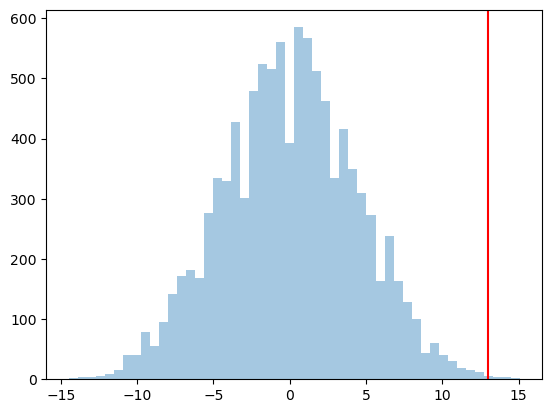

In [13]:
plt.hist(sig_means, bins=50, alpha=0.4);
plt.axvline(actual_effect, 0, 1, color="red");

As a comparison, consider the case in which placebos had a much wider spread, between 50, and 450. Simply add 13 to each placebo value to get a dosage value. The mean difference would still be 13. But now, 13 would be way inside the histogram, and the effect would not be a significant one, and could have happened by chance.

*Statistically significant does not mean important*. Thats a question of, how large is the effect, or where are the confidence intervals for the effect. For instance, if a statistically significant increase in mortality was a mean of 5 days over 5 years by drug over placebo, you would not consider the effect important.

## Bootstrap to estimate size of effect

Here we randomize labels within the group, take means, and subtract. Here is an example

In [14]:
placebo_bs = np.random.choice(list(range(10)), size=(10000, 10))
drug_bs = np.random.choice(list(range(10, 19)), size=(10000, 9))

In [15]:
placebo_bs[0,:]

array([2, 9, 2, 2, 1, 7, 9, 6, 5, 4])

In [16]:
df.iloc[placebo_bs[0,:]]

,dosage,label
2,58,P
9,46,P
2,58,P
2,58,P
1,51,P
7,47,P
9,46,P
6,42,P
5,52,P
4,55,P


Here is the effect:

In [17]:
df.iloc[drug_bs[0,:]].dosage.mean() - df.iloc[placebo_bs[0,:]].dosage.mean()

13.366666666666674

Let us do this 10000 times.

In [18]:
effect_diffs = np.zeros(10000)
for i in range(10000):
    effect_diffs[i] = df.iloc[drug_bs[i,:]].dosage.mean() - df.iloc[placebo_bs[i,:]].dosage.mean()

In [19]:
percs = np.percentile(effect_diffs, [5, 50, 95])
percs

array([ 7.7       , 12.97777778, 18.02222222])

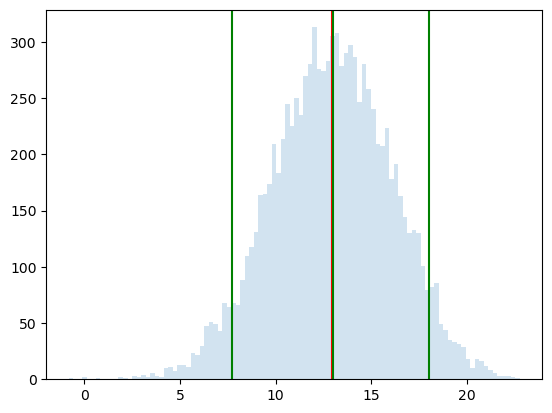

In [20]:
plt.hist(effect_diffs, bins=100, alpha=0.2);
plt.axvline(actual_effect, 0, 1, color="red");
for p in percs:
    plt.axvline(p, 0, 1, color="green");

That is, 90% of the time, the drug is 7.53 to 18.12 more effective than placebo. The average value of placebo in our sample was 50. This makes the drug 13 to 33% more effective, roghly, which seems it might be an important effect.

If you have such a confidence interval, why do a significance test. Consider the extreme case of 2 data points, wel separated. The confidence interval is tight around the difference. But a permutation test would show that half the time, you will by random chance, get a difference just as big as  the observed one. Intuitively this is too little data to show significance, and this "half the time" bears that out...